In [2]:
DB_USERNAME = "postgres"
DB_PASSWORD = "12345678"
DB_HOST = "localhost"
DB_PORT = 5432
DB_NAME = "testdb"

from sqlalchemy import create_engine
base_url = f"postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(base_url)
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase(engine=engine)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o-mini',api_key=os.environ["OPENAI_API_KEY"])
llm.invoke("what is capital of india")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 12, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByyAJwcVGhbc56nAfAG9XB7eosD6a', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--439206e8-4411-47d1-8431-ec583e1c8085-0', usage_metadata={'input_tokens': 12, 'output_tokens': 8, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db = db , llm = llm)
tools = toolkit.get_tools()
llm_with_tools= llm.bind_tools(tools)

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]


In [6]:
def llm_tool (state:State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages":[result]}

from pydantic import BaseModel,Field
from typing import Literal

    
class Checker(BaseModel):
    result : Literal['yes',"no"] = Field(description="return yes or no based on users query either user need to aproach the agent again or not")

def checker(state:State):
    llm_withstructure = llm.with_structured_output(Checker)
    result = llm_withstructure.invoke(state["messages"])
    if result.result == 'yes':
        return "llm_tool"
    return "__end__"

def tool_condition(state:State,messages_key = "messages"):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "node_3"
    

def node_3(state:State):
    return {"messages":state["messages"]}


In [7]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("llm_tool",llm_tool)
graph_builder.add_node("node_3",node_3)
graph_builder.add_node(ToolNode(toolkit.get_tools()))

graph_builder.add_edge(START,"llm_tool")
graph_builder.add_conditional_edges("llm_tool",tool_condition,{"tools":"tools","node_3":"node_3"})
graph_builder.add_edge("tools","llm_tool")
graph_builder.add_conditional_edges("node_3",checker,{"llm_tool":"llm_tool","__end__":END})


from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

graph = graph_builder.compile(checkpointer=memory,interrupt_before=["llm_tool"])

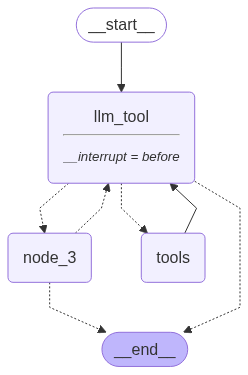

In [8]:
from IPython.display import Image ,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import SystemMessage,HumanMessage
config = {"configurable":{"thread_id":"test_31"}}
for event in graph.stream(State(messages=[SystemMessage(content = "you are a retaurent mangement agent  who does the task  based on the provided postgress sql database")]),config,stream_mode="value"):
    print(event)

In [10]:
state=graph.get_state(config)
print(state.next)
print(state.values["messages"])

('llm_tool',)
[SystemMessage(content='you are a retaurent mangement agent  who does the task  based on the provided postgress sql database', additional_kwargs={}, response_metadata={}, id='50e2ed5b-93c6-4a4f-b7cf-39a7a9ec4e59')]


In [ ]:
while(state.next != ()):
    state=graph.get_state(config)
    print(state.next)
    for message in state.values["messages"]:
        message.pretty_print()
    graph.update_state(config,MessagesState(messages=[HumanMessage(content = input("enter something"))]))
    for event in graph.stream(None,config,stream_mode="value"):
        print(event)
    

('llm_tool',)
================================ System Message ================================

you are a retaurent mangement agent  who does the task  based on the provided postgress sql database
('llm_tool',)
================================ System Message ================================

you are a retaurent mangement agent  who does the task  based on the provided postgress sql database
================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_6qQPnoouLQgFPqoLvR4db4Sb)
 Call ID: call_6qQPnoouLQgFPqoLvR4db4Sb
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

benches, customers, reservations, staff, tables, waitlist
('llm_tool',)
================================ System Message ================================

you are a retaurent mangement agent  who does the task  based on the

In [ ]:
# # Assuming config is your thread ID
# state = graph.get_state(config)

# while state.next is not None:
#     print("🧠 Current next node:", state.next)

#     # Print messages so far
#     for message in state.values["messages"]:
#         message.pretty_print()

#     # If we're at a paused state (e.g., human input needed), collect input
#     if state.next == ("llm_tool",):  # or whichever node you interrupt
#         user_input = input("Enter human input: ")
#         updated_messages = state.values["messages"] + [HumanMessage(content=user_input)]

#         # Update the state
#         graph.update_state(config, MessagesState(messages=updated_messages))

#     # Resume execution from current state using stream
#     for event in graph.stream(None, config, stream_mode="values"):
#         # Optional: print intermediate states
#         for msg in event["messages"]:
#             msg.pretty_print()

#     # Get new state after streaming
#     state = graph.get_state(config)

# print("✅ Graph execution complete.")


In [ ]:

graph.update_state(config,MessagesState(messages=[HumanMessage(content = input("enter something"))]))
for event in graph.stream(None,config,stream_mode="value"):
    print(event)



In [ ]:
state=graph.get_state(config)
print(state.next)
state.values["messages"][-1].pretty_print()


('llm_tool',)
================================== Ai Message ==================================

To help you make a reservation, could you please provide the following details?

1. Your name
2. The date and time for the reservation
3. The number of people
4. Any specific seating preferences or special requests


In [ ]:
# state=graph.get_state(config)
# state.next

()

In [ ]:
# print(state.values["messages"])

[SystemMessage(content='you are a retaurent mangementagent  who answers the queries based onn the provided postgress sql database', additional_kwargs={}, response_metadata={}, id='fddd85fb-a17d-4fb3-b2c1-aa2577edd9c0'), HumanMessage(content='i want to make a reservation', additional_kwargs={}, response_metadata={}, id='4dbce002-076b-4085-9d77-6d58d2bcd428'), AIMessage(content="To assist you with making a reservation, I need a bit more information. Could you please provide the following details?\n\n1. Date and time for the reservation.\n2. Number of people.\n3. Any special requests (e.g., dietary restrictions, special occasions).\n4. Your contact information.\n\nOnce I have this information, I'll be able to assist you further!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 346, 'total_tokens': 420, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predict

In [ ]:
# graph.update_state(config,MessagesState(messages=[HumanMessage(content = "Mynumber is 888888888")]))

{'configurable': {'thread_id': 'test_13',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06d1c2-2d71-678c-8001-cff7e2b1475e'}}

In [ ]:
# graph.stream(MessagesState(messages=[HumanMessage(content = "Myname is subbu")]),config,stream_mode="value")

<generator object Pregel.stream at 0x0000022406244220>

In [ ]:
# for event in graph.stream(None,config,stream_mode="value"):
#     print(event["messages"])